In [4]:
import jsonlines

with jsonlines.open('data/train.jsonl') as reader:
    train_data = [obj for obj in reader]

with jsonlines.open('data/dev_seen.jsonl') as reader:
    val_data = [obj for obj in reader]

with jsonlines.open('data/test_seen.jsonl') as reader:
    test_data = [obj for obj in reader]


In [5]:
import torch
torch.cuda.empty_cache()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from transformers import BertModel, BertTokenizer
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Define the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the hyperparameters
batch_size = 32
learning_rate = 0.0001
num_epochs = 10

# Define the dataset class


class MemesDataset(Dataset):
    def __init__(self, data, tokenizer, image_transform):
        self.data = data
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.img_dir = "data/"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_path = os.path.join(self.img_dir, item['img'])
        image = Image.open(img_path).convert("RGB")
        image = self.image_transform(image)
        text = item['text']
        tokenized_text = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=128, padding='max_length', truncation=True)
        input_ids = torch.tensor(tokenized_text['input_ids'])
        attention_mask = torch.tensor(tokenized_text['attention_mask'])
        label = torch.tensor(item['label'])
        return {'image': image, 'input_ids': input_ids, 'attention_mask': attention_mask, 'label': label}

# Define the image encoder


class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 1024)

    def forward(self, x):
        x = self.cnn(x)
        x = nn.functional.relu(x)
        return x

# Define the text encoder


class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        return pooled_output

# Define the multimodal classifier




image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Load the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_data = MemesDataset(train_data, tokenizer, image_transform)
val_data = MemesDataset(val_data, tokenizer, image_transform)
test_data = MemesDataset(test_data, tokenizer, image_transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)




In [7]:
class MultimodalClassifier(nn.Module):
    def __init__(self):
        super(MultimodalClassifier, self).__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.fc1 = nn.Linear(1792, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, image, input_ids, attention_mask):
        image_embedding = self.image_encoder(image)
        text_embedding = self.text_encoder(input_ids, attention_mask)
        multimodal_embedding = torch.cat(
            (image_embedding, text_embedding), dim=1)
        # print(multimodal_embedding.shape)
        x = self.fc1(multimodal_embedding)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = MultimodalClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_correctt=0
num_totalt=0

tr_loss_arr = []
tr_acc_arr = []

val_loss_arr = []
val_acc_arr = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        image = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(image, input_ids, attention_mask)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * image.size(0)
        num_correctt += (torch.argmax(outputs, axis=1) == label).sum().item()
        num_totalt += label.size(0)
        
    epoch_loss = running_loss / len(train_data)
    train_acc = num_correctt / num_totalt
    tr_loss_arr.append(epoch_loss)
    tr_acc_arr.append(train_acc)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}'.format(epoch +
        1, num_epochs, epoch_loss, train_acc))

    # Evaluate the model on the validation set
    model.eval()
    running_loss = 0.0
    num_correct = 0
    num_total = 0
    with torch.no_grad():
        for batch in val_loader:
            image = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['label'].to(device)

            outputs = model(image, input_ids, attention_mask)
            loss = criterion(outputs, label)

            running_loss += loss.item() * image.size(0)
            num_correct += (torch.argmax(outputs, axis=1) == label).sum().item()
            num_total += label.size(0)

    val_loss = running_loss / len(val_data)
    val_acc = num_correct / num_total
    
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    print('Epoch [{}/{}], Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch +
        1, num_epochs, val_loss, val_acc))
        
    
        


/home/aayush/a/dl_assignments/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aayush/a/dl_assignments/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship

Epoch [1/10], Train Loss: 0.5454, Train Acc: 0.7394
Epoch [1/10], Val Loss: 0.8745, Val Acc: 0.5680
Epoch [2/10], Train Loss: 0.4563, Train Acc: 0.7656
Epoch [2/10], Val Loss: 0.8156, Val Acc: 0.5760
Epoch [3/10], Train Loss: 0.3609, Train Acc: 0.7904
Epoch [3/10], Val Loss: 1.2866, Val Acc: 0.5580
Epoch [4/10], Train Loss: 0.2608, Train Acc: 0.8159
Epoch [4/10], Val Loss: 1.2750, Val Acc: 0.5680
Epoch [5/10], Train Loss: 0.1836, Train Acc: 0.8382
Epoch [5/10], Val Loss: 1.2416, Val Acc: 0.6040
Epoch [6/10], Train Loss: 0.1421, Train Acc: 0.8568
Epoch [6/10], Val Loss: 1.7927, Val Acc: 0.5840
Epoch [7/10], Train Loss: 0.1016, Train Acc: 0.8723
Epoch [7/10], Val Loss: 1.5592, Val Acc: 0.5980
Epoch [8/10], Train Loss: 0.0850, Train Acc: 0.8847
Epoch [8/10], Val Loss: 2.0857, Val Acc: 0.5580
Epoch [9/10], Train Loss: 0.0789, Train Acc: 0.8945
Epoch [9/10], Val Loss: 1.6708, Val Acc: 0.5820
Epoch [10/10], Train Loss: 0.0493, Train Acc: 0.9034
Epoch [10/10], Val Loss: 1.9289, Val Acc: 0.582

In [8]:
torch.save(model.state_dict(), 'data/modelq3.pt')

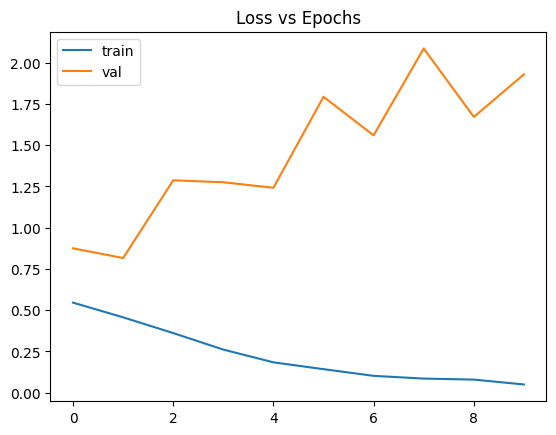

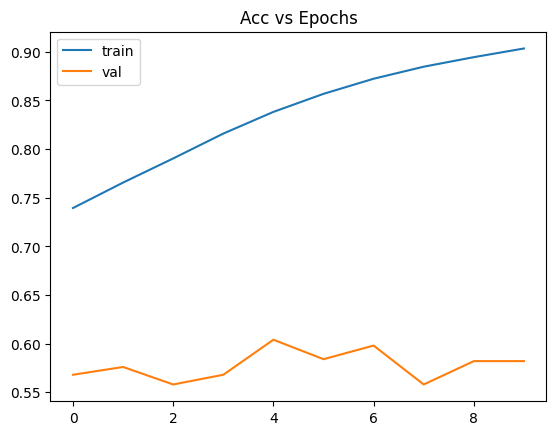

In [9]:
import matplotlib.pyplot as plt

plt.plot(tr_loss_arr, label='train')
plt.plot(val_loss_arr, label='val')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

plt.plot(tr_acc_arr, label='train')
plt.plot(val_acc_arr, label='val')
plt.title('Acc vs Epochs')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

true_labels = []
pred_labels = []

for batch in test_loader:
    # Get the image and text inputs and labels for the batch
    image = batch['image'].to(device)
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    label = batch['label'].to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(image, input_ids, attention_mask)
        predictions = torch.argmax(outputs, axis=1)

    # Add true labels and predicted labels to the lists
    true_labels.extend(label.tolist())
    pred_labels.extend(predictions.tolist())

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')





In [19]:
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1:{:.4f}'.format(f1))

Accuracy: 0.6130
Precision: 0.6309
Recall: 0.6089
F1:0.5942


In [20]:
from sklearn.metrics import classification_report

target_names = ['not_hateful', 'hateful']
report = classification_report(
    true_labels, pred_labels, target_names=target_names)

print('Class-wise Metrics:')
print(report)


Class-wise Metrics:
              precision    recall  f1-score   support

 not_hateful       0.59      0.81      0.68       510
     hateful       0.67      0.41      0.51       490

    accuracy                           0.61      1000
   macro avg       0.63      0.61      0.59      1000
weighted avg       0.63      0.61      0.60      1000

